<a href="https://colab.research.google.com/github/samitha278/gpt2-lite/blob/main/optimize3_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gdown
import time
import math
import matplotlib.pyplot as plt

import tiktoken

from dataclasses import dataclass

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Data file doenload

file_id = "1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz"
url = f"https://drive.google.com/uc?id={file_id}"

output = "input.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz
To: /content/input.txt
100%|██████████| 1.12M/1.12M [00:00<00:00, 62.7MB/s]


'input.txt'

# GPT-2 Model

In [3]:
@dataclass
class GPT2Config:
    block_size : int = 1024
    vocab_size : int = 50257
    n_layer : int = 12
    n_head : int = 12
    n_embd : int = 768


# ----------------------------------------------------------------------------------


class GPT2(nn.Module):

    def __init__(self,config):
        super().__init__()

        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.n_embd),
            wpe = nn.Embedding(config.block_size,config.n_embd),

            h = nn.ModuleList([Block(config) for i in range(config.n_layer)]),

            ln_f = nn.LayerNorm(config.n_embd),

        ))

        self.lm_head = nn.Linear(config.n_embd,config.vocab_size, bias=False)


        #weight sharing
        self.transformer.wte.weight = self.lm_head.weight
        #Save ~38M parameters

        self.apply(self._init_weights)



    def _init_weights(self,module):

        if isinstance(module,nn.Linear):
            std = 0.02
            if hasattr(module,'FLAG'):
                std *= (2*self.config.n_layer) ** -0.5           #scaledown std
            torch.nn.init.normal_(module.weight,mean=0.0,std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module,nn.Embedding):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)



    def forward(self,x,targets= None):

        B,T = x.shape
        assert T<= self.config.block_size   # positional embd table max size = block_size
        tx = self.transformer.wte(x)       #token embedding
        px = self.transformer.wpe(torch.arange(0,T,self.config.block_size,device=device)) #positional embedding

        x = tx+px     # add both

        for block in self.transformer.h:
          x = block(x)

        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(B*T,-1) ,targets.view(-1))
            return logits,loss



    @classmethod
    def from_pretrained(cls, model_type='gpt2'):
        from transformers import GPT2LMHeadModel
        assert model_type == 'gpt2'

        config_args = dict(n_layer=12, n_head=12, n_embd=768, vocab_size=50257, block_size=1024)
        config = GPT2Config(**config_args)
        model = GPT2(config)

        sd = model.state_dict()
        sd_keys = [k for k in sd.keys() if not k.endswith('.attn.bias')]

        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        sd_keys_hf = [k for k in sd_hf.keys() if not k.endswith(('.attn.masked_bias', '.attn.bias'))]

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(sd_keys_hf) == len(sd_keys)

        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


# ----------------------------------------------------------------------------------



class Block(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config

        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)


    def forward(self,x):

        x = self.attn(self.ln_1(x)) + x
        x = self.mlp(self.ln_2(x)) + x

        return x



# ----------------------------------------------------------------------------------


class MLP(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config

        self.c_fc = nn.Linear(config.n_embd,4*config.n_embd)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4*config.n_embd,config.n_embd)
        self.c_proj.FLAG = 1


    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        return x

# ----------------------------------------------------------------------------------

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()

        block_size = config.block_size

        self.n_head = n_head = config.n_head
        self.n_embd = n_embd = config.n_embd


        assert n_embd % n_head == 0
        self.head_size = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3 * n_embd)     # fan out : n_head * 3 * head_size

        self.c_proj = nn.Linear(n_embd, n_embd)

        self.c_proj.FLAG = 1

        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size)))



    def forward(self, x):
        B, T, C = x.size()  # C = n_embd = n_head * head_size

        qkv = self.c_attn(x)    # B,T, 3*n_embd

        q, k, v = qkv.split(self.n_embd, dim=2)    # each : B,T, n_head * head_size

        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # B, n_head, T, head_size
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # ""
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)    # ""

        # att = (q @ k.transpose(-2, -1)) * (self.head_size**-0.5)         # B, n_head, T, T
        # att = att.masked_fill(self.bias[:T,:T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)

        # y = att @ v        # B, n_head, T, head_size


        # Flash Attention
        y = F.scaled_dot_product_attention(q,k,v,is_causal=True)


        y = y.transpose(1, 2).contiguous().view(B, T, C)   # B, T , n_embd   (n_embd = n_head * head_size)

        y = self.c_proj(y)
        return y





# ----------------------------------------------------------------------------------

class DataLoader():

  def __init__(self,B,T):

    self.B = B
    self.T = T

    with open('input.txt', 'r') as f:
      text = f.read()

    enc = tiktoken.get_encoding('gpt2')
    self.tokens = torch.tensor(enc.encode(text))

    print(f'1 epoch size: {len(self.tokens//B*T)}')

    self.count = 0



  def get_batch(self):

    B,T = self.B , self.T

    temp = self.tokens[self.count:self.count+B*T+1]

    x = temp[:-1].view(B,T)   #inputs
    y = temp[1:].view(B,T)    #targets

    self.count += B*T

    # Reset
    if (self.count+B*T+1) > len(self.tokens):
      self.count = 0

    return x,y


# Train

In [4]:
B = 4
T = 1024


torch.manual_seed(278)
if torch.cuda.is_available():
  torch.cuda.manual_seed(278)


model = GPT2(GPT2Config(vocab_size = 50304))
model = model.to(device)
model = torch.compile(model)    # compile model into optimize form


data = DataLoader(B,T)

# _____________________________________________________________________________

# Learning Rate
max_lr = 6e-4
min_lr = max_lr * 0.1

max_iter = 1000
warmup_steps = max_iter * 0.05

def next_lr(i):
  # warmup stage : linear
  if i < warmup_steps :
    return (max_lr/warmup_steps) * (i+1)

  if i > max_iter:
    return min_lr

  # cosine dacay
  decay_ratio = (i-warmup_steps) / (max_iter-warmup_steps)
  assert 0<= decay_ratio <=1
  c = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))

  return min_lr + c * (max_lr - min_lr)


# _____________________________________________________________________________


losses = torch.zeros((max_iter,))
norms = torch.zeros((max_iter,))
lrs = torch.zeros((max_iter,))


optimizer = torch.optim.AdamW(model.parameters(),lr = 6e-4,betas = (0.9,0.95),eps = 1e-8)
#Gradient Scalar
scaler = torch.amp.GradScaler(device)     # Prevents gradient underflow when using FP16

#optimize
for i in range(max_iter):

  t0 = time.time()   # time start

  xb , yb = data.get_batch()
  xb , yb = xb.to(device),yb.to(device)

  #AMP
  with torch.autocast(device_type=device, dtype=torch.float16):   # FP16
    logits , loss = model(xb,yb)

  optimizer.zero_grad()

  scaler.scale(loss).backward()     # multiplies loss by a scale factor

  norm = nn.utils.clip_grad_norm_(model.parameters(),1.0)    # inplace gradient clipping

  # find and set learning rate
  lr = next_lr(i)

  # update optimizer this new lr
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  scaler.step(optimizer)            # unscales gradients then call optimizer step
  scaler.update()                   # adjusts the scale factor automatically each iteration


  torch.cuda.synchronize() if torch.cuda.is_available() else None

  t1 = time.time()   # time end
  t = (t1 - t0)*1000 # ms

  losses[i] = loss.item()
  norms[i] = norm.item()
  lrs[i] = lr

  if i%100==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {t:.4f} ms  norm:{norm.item():.4f}  lr:{lr:.4e}')

1 epoch size: 338025


W0926 05:06:59.726000 1952 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


0/1000  11.0500  31587.0152 ms  norm:3083475.2500  lr:1.1999999999999999e-05
100/1000  6.3045  273.0086 ms  norm:127163.6641  lr:0.000596317551918735
200/1000  5.5345  272.9156 ms  norm:159696.4688  lr:0.000567457912825752
300/1000  5.3184  296.1235 ms  norm:166981.0938  lr:0.00051286602433895
400/1000  5.0724  283.6609 ms  norm:181526.6875  lr:0.0004384577646563017
500/1000  4.7149  280.0109 ms  norm:159570.0469  lr:0.0003522964232775297
600/1000  4.9071  283.3986 ms  norm:147432.3750  lr:0.0002637189184719842
700/1000  5.0193  284.6563 ms  norm:164736.5156  lr:0.00018232399730694476
800/1000  4.6939  285.3720 ms  norm:204243.5781  lr:0.00011693206246297374
900/1000  4.9968  288.0721 ms  norm:226479.4844  lr:7.462934474082864e-05


### Losses

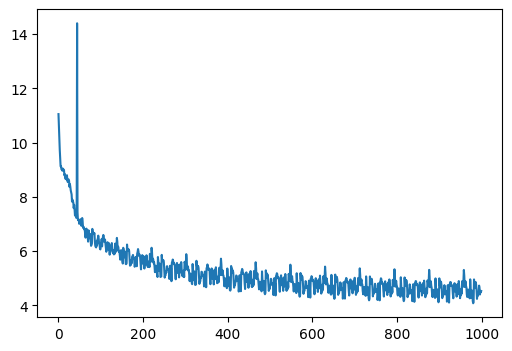

In [5]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

### Norms

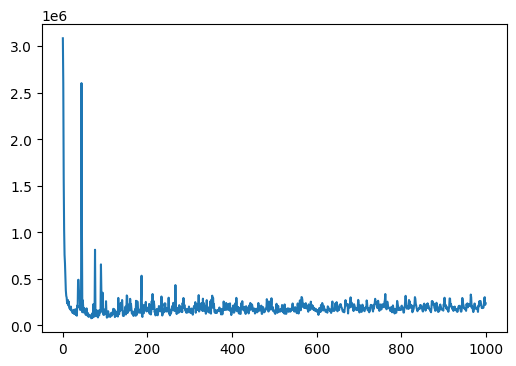

In [6]:
plt.figure(figsize=(6,4))
plt.plot(norms)
plt.show()

### Learning Rates

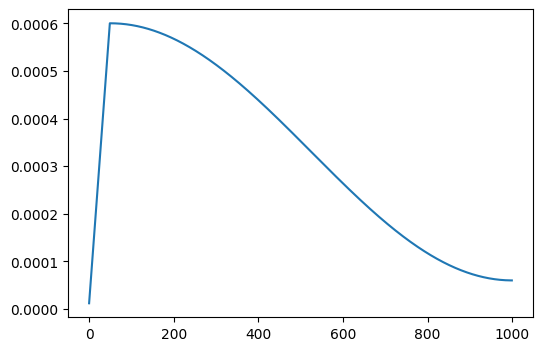

In [7]:
plt.figure(figsize=(6,4))
plt.plot(lrs)
plt.show()